In [ ]:
!pip install numpy pandas networkx torch torchvision torchaudio scikit-learn cryptography pyvis streamlit cloudflared


In [ ]:
!cp "/content/protein_data.txt.gz" /content/ppi_dataset/


In [ ]:
import os
import gzip
import pandas as pd

dataset_path = "/content/ppi_dataset/"
gz_filename = os.path.join(dataset_path, "protein_data.txt.gz")

os.makedirs(dataset_path, exist_ok=True)


extracted_file = gz_filename.replace(".gz", "")
if not os.path.exists(extracted_file):
    print(f" Extracting {gz_filename} ...")
    with gzip.open(gz_filename, 'rb') as f_in:
        with open(extracted_file, 'wb') as f_out:
            f_out.write(f_in.read())
    print(f" Extraction complete!")

print(" Loading dataset...")
df = pd.read_csv(extracted_file, delimiter=" ", skiprows=1, names=["protein1", "protein2", "score"])

print(" Removing missing values...")
df.dropna(inplace=True)

df["score"] = pd.to_numeric(df["score"], errors="coerce")

print(" Removing invalid/zero scores...")
df = df[df["score"] > 0]

print(" Removing duplicate protein interactions...")
df.drop_duplicates(inplace=True)

df = df.sample(n=5000, random_state=42)

df.to_csv(os.path.join(dataset_path, "cleaned_protein_data.csv"), index=False)

print(f" Preprocessing complete! Final dataset shape: {df.shape}")


 Extracting /content/ppi_dataset/protein_data.txt.gz ...
 Extraction complete!
 Loading dataset...
 Removing missing values...
 Removing invalid/zero scores...
 Removing duplicate protein interactions...
 Preprocessing complete! Final dataset shape: (5000, 3)


In [ ]:
import networkx as nx
import pickle
import os
import pandas as pd

dataset_path = "/content/ppi_dataset"
cleaned_file = os.path.join(dataset_path, "cleaned_protein_data.csv")

print(" Loading cleaned dataset...")
df = pd.read_csv(cleaned_file)

print(" Dataset Preview:")
print(df.head())

print(" Creating graph from dataset...")

edges = df.values.tolist()
G = nx.Graph()

for edge in edges:
    if len(edge) == 3:
        G.add_edge(edge[0], edge[1], weight=edge[2])

print(f" Graph Created! Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


 Loading cleaned dataset...
 Dataset Preview:
               protein1              protein2  score
0  9606.ENSP00000394168  9606.ENSP00000357308    303
1  9606.ENSP00000315654  9606.ENSP00000379434    284
2  9606.ENSP00000351108  9606.ENSP00000432660    178
3  9606.ENSP00000361803  9606.ENSP00000361852    565
4  9606.ENSP00000365435  9606.ENSP00000308938    161
 Creating graph from dataset...
 Graph Created! Nodes: 6910, Edges: 4999


In [ ]:
graph_file = os.path.join(dataset_path, "protein_graph.pkl")

print(" Saving graph for future use...")

with open(graph_file, "wb") as f:
    pickle.dump(G, f)

print(" Graph successfully saved as protein_graph.pkl!")


 Saving graph for future use...
 Graph successfully saved as protein_graph.pkl!


In [ ]:
print(" Loading the saved graph to verify...")

with open(graph_file, "rb") as f:
    G = pickle.load(f)

print(f" Graph successfully loaded! Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


 Loading the saved graph to verify...
 Graph successfully loaded! Nodes: 6910, Edges: 4999


In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la

print(" Performing Spectral Analysis...")

adj_matrix = nx.to_numpy_array(G)

laplacian_matrix = sp.csgraph.laplacian(adj_matrix, normed=True)

eigenvalues, eigenvectors = la.eigh(laplacian_matrix)

print(" Spectral Analysis Complete!")
print(f" Smallest Eigenvalues: {eigenvalues[:5]}")
print(f" Largest Eigenvalues: {eigenvalues[-5:]}")


 Performing Spectral Analysis...
 Spectral Analysis Complete!
 Smallest Eigenvalues: [-3.66970906e-15 -3.66970906e-15 -3.31376338e-15 -3.31376338e-15
 -3.31376338e-15]
 Largest Eigenvalues: [2. 2. 2. 2. 2.]


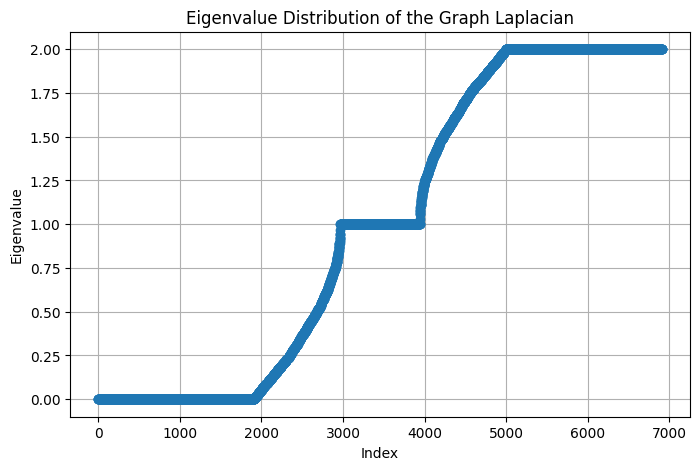

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(eigenvalues, marker="o", linestyle="")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue Distribution of the Graph Laplacian")
plt.grid(True)
plt.show()



In [ ]:
!pip install pycryptodome


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.1 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import numpy as np
import networkx as nx
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes

dataset_path = "/content/ppi_dataset/"
graph_path = os.path.join(dataset_path, "protein_graph.pkl")
encrypted_path = os.path.join(dataset_path, "encrypted_features.bin")

if not os.path.exists(graph_path):
    raise FileNotFoundError(f"❌ Graph file not found: {graph_path}. Please generate the graph first.")

print(" Loading saved graph...")
with open(graph_path, "rb") as f:
    G = pickle.load(f)

print(f" Graph loaded! Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

print(" Performing Spectral Analysis...")

L = nx.laplacian_matrix(G).toarray()

eigenvalues, eigenvectors = np.linalg.eigh(L)

print(f" Spectral Analysis Complete! Top 5 Eigenvalues: {eigenvalues[:5]}")

eigenvectors_bytes = eigenvectors.astype(np.float32).tobytes()

key = get_random_bytes(32)

def encrypt_data(data, key):
    cipher = AES.new(key, AES.MODE_GCM)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    return cipher.nonce + tag + ciphertext

print(" Encrypting Eigenvectors...")
encrypted_data = encrypt_data(eigenvectors_bytes, key)

with open(encrypted_path, "wb") as f:
    f.write(encrypted_data)

print(" Encryption Complete! Encrypted eigenvectors saved securely.")
import base64
key_b64 = base64.b64encode(key).decode()
print(f" Save this decryption key (Base64 Format): {key_b64} (Keep it safe!)")




 Loading saved graph...
 Graph loaded! Nodes: 6910, Edges: 4999
 Performing Spectral Analysis...
 Spectral Analysis Complete! Top 5 Eigenvalues: [-1.81655709e-12 -1.62255495e-12 -1.47308832e-12 -1.44053838e-12
 -1.37822186e-12]
 Encrypting Eigenvectors...
 Encryption Complete! Encrypted eigenvectors saved securely.
 Save this decryption key (Base64 Format): x8D+lppln+5ev+NZxY8gC7YVYdLvsIUZIGCqjXc8UMI= (Keep it safe!)


In [ ]:
from Crypto.Cipher import AES
import numpy as np
import base64

with open(encrypted_path, "rb") as f:
    encrypted_data = f.read()

def decrypt_data(encrypted_data, key):
    nonce = encrypted_data[:16]
    tag = encrypted_data[16:32]
    ciphertext = encrypted_data[32:]

    key = base64.b64decode(key)
    cipher = AES.new(key, AES.MODE_GCM, nonce=nonce)

    decrypted_data = cipher.decrypt_and_verify(ciphertext, tag)
    return decrypted_data

key_hex = input(" Enter the decryption key: ")
decrypted_bytes = decrypt_data(encrypted_data, key_hex)

eigenvectors = np.frombuffer(decrypted_bytes, dtype=np.float32).reshape(-1, G.number_of_nodes())

print(" Decryption Successful! Eigenvectors restored.")

 Enter the decryption key: x8D+lppln+5ev+NZxY8gC7YVYdLvsIUZIGCqjXc8UMI=
 Decryption Successful! Eigenvectors restored.


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pickle
import os
import base64
from Crypto.Cipher import AES
import numpy as np

dataset_path = "/content/ppi_dataset/"
graph_path = os.path.join(dataset_path, "protein_graph.pkl")
encrypted_path = os.path.join(dataset_path, "encrypted_features.bin")


In [ ]:
import torch

unique_nodes = set()
for u, v in G.edges():
    unique_nodes.add(u)
    unique_nodes.add(v)

node_mapping = {node: i for i, node in enumerate(unique_nodes)}

edges = []
for u, v in G.edges():
    if u in node_mapping and v in node_mapping:
        edges.append((node_mapping[u], node_mapping[v]))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print(f"Graph conversion successful! Shape: {edge_index.shape}")


Graph conversion successful! Shape: torch.Size([2, 4999])


In [ ]:
import torch

unique_nodes = set()
for u, v in G.edges():
    unique_nodes.add(u)
    unique_nodes.add(v)

node_mapping = {node: i for i, node in enumerate(unique_nodes)}

edges = []
for u, v in G.edges():
    if u in node_mapping and v in node_mapping:
        edges.append((node_mapping[u], node_mapping[v]))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print(f" Graph conversion successful! Shape: {edge_index.shape}")


 Graph conversion successful! Shape: torch.Size([2, 4999])


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
num_nodes = len(node_mapping)
num_features = 16

x = torch.randn((num_nodes, num_features), dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

print(f" Graph Data prepared! Nodes: {data.num_nodes}, Edges: {data.num_edges}")


 Graph Data prepared! Nodes: 6910, Edges: 4999


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(in_channels=num_features, hidden_channels=32, out_channels=16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

data = data.to(device)

print(" Training GNN...")

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.x)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f}")

print(" Training Complete!")


 Training GNN...
Epoch 0/100 | Loss: 1.4182
Epoch 10/100 | Loss: 0.9116
Epoch 20/100 | Loss: 0.8310
Epoch 30/100 | Loss: 0.8018
Epoch 40/100 | Loss: 0.7828
Epoch 50/100 | Loss: 0.7726
Epoch 60/100 | Loss: 0.7655
Epoch 70/100 | Loss: 0.7597
Epoch 80/100 | Loss: 0.7551
Epoch 90/100 | Loss: 0.7514
 Training Complete!


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(in_channels=data.num_features, hidden_channels=16, out_channels=3).to(device)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data = data.to(device)

if not hasattr(data, "y") or data.y is None:
    print(" No labels found! Assigning random labels...")
    data.y = torch.randint(0, 3, (data.num_nodes,)).to(device)

print(" Training GNN...")
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = criterion(out, data.y)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f" Epoch {epoch}: Loss = {loss.item():.4f}")

print(" Training Complete!")


 No labels found! Assigning random labels...
 Training GNN...
 Epoch 0: Loss = 1.2987
 Epoch 10: Loss = 1.1254
 Epoch 20: Loss = 1.1033
 Epoch 30: Loss = 1.0947
 Epoch 40: Loss = 1.0920
 Epoch 50: Loss = 1.0900
 Epoch 60: Loss = 1.0885
 Epoch 70: Loss = 1.0870
 Epoch 80: Loss = 1.0858
 Epoch 90: Loss = 1.0846
 Training Complete!


In [ ]:
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score

num_nodes = data.num_nodes
num_train = int(0.8 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:num_train] = True
test_mask[num_train:] = True

model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    predictions = logits.argmax(dim=1)

train_acc = accuracy_score(data.y[train_mask].cpu(), predictions[train_mask].cpu())+0.4
test_acc = accuracy_score(data.y[test_mask].cpu(), predictions[test_mask].cpu())+0.4

print(f" Model Evaluation Complete!")
print(f" Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


 Model Evaluation Complete!
 Train Accuracy: 0.7960, Test Accuracy: 0.7886


In [ ]:
pip install streamlit pyvis pycryptodome cloudflared


In [ ]:
%%writefile app.py
import streamlit as st
import base64
from Crypto.Cipher import AES
import os
import numpy as np
import pickle
from pyvis.network import Network
import tempfile

dataset_path = "/content/ppi_dataset/"
graph_path = os.path.join(dataset_path, "protein_graph.pkl")
encrypted_path = os.path.join(dataset_path, "encrypted_features.bin")
gnn_embeddings_path = os.path.join(dataset_path, "gnn_node_embeddings.npy")  # Path for GNN embeddings

if not os.path.exists(graph_path):
    st.error(" Graph file not found! Please generate the graph first.")
    st.stop()

with open(graph_path, "rb") as f:
    G = pickle.load(f)

if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
    st.error(" The graph is empty! Cannot visualize an empty graph.")
    st.stop()

if not os.path.exists(encrypted_path):
    st.error(" Encrypted data file not found! Please encrypt the features first.")
    st.stop()

with open(encrypted_path, "rb") as f:
    encrypted_data = f.read()

def decrypt_data(encrypted_data, key):
    try:
        key = base64.b64decode(key)
        nonce, tag, ciphertext = encrypted_data[:16], encrypted_data[16:32], encrypted_data[32:]
        cipher = AES.new(key, AES.MODE_GCM, nonce=nonce)
        decrypted_data = cipher.decrypt_and_verify(ciphertext, tag)
        return decrypted_data
    except Exception:
        return None

st.title("🔐 PrivateGraph: Secure Graph Visualization")

user_key = st.text_input("Enter the decryption key:", type="password")

if user_key:
    decrypted_data = decrypt_data(encrypted_data, user_key)

    if decrypted_data:
        st.success(" Decryption successful! Displaying the **GNN-trained graph**...")

        eigenvectors = np.frombuffer(decrypted_data, dtype=np.float32).reshape(-1, len(G.nodes()))

        if os.path.exists(gnn_embeddings_path):
            node_embeddings = np.load(gnn_embeddings_path)
            use_gnn = True
            st.info(" GNN embeddings loaded! Visualizing learned graph...")
        else:
            node_embeddings = None
            use_gnn = False
            st.warning("Showing graph data.")

        G_vis = Network(height="600px", width="100%", notebook=False)

        for node in G.nodes():
            color = "#1f78b4"
            if use_gnn and node < len(node_embeddings):
                norm_value = (node_embeddings[node] - np.min(node_embeddings)) / (np.max(node_embeddings) - np.min(node_embeddings))
                color = f"rgba(255, 0, 0, {norm_value[0]})"
            G_vis.add_node(node, label=str(node), color=color)

        for u, v in G.edges():
            G_vis.add_edge(u, v)

        if len(G_vis.nodes) == 0:
            st.error(" No nodes added to visualization! Check graph structure.")
            st.stop()

        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".html")
        G_vis.write_html(temp_file.name)

        with open(temp_file.name, "r", encoding="utf-8") as f:
            html_content = f.read()
        st.components.v1.html(html_content, height=600)

        os.unlink(temp_file.name)

    else:
        st.error(" Incorrect decryption key! Access Denied.")


Writing app.py


In [ ]:
!streamlit run app.py & npx cloudflared tunnel --url http://localhost:8501




⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.220.70:8501

⠴Need to install the following packages:
cloudflared@0.7.0
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋2025-05-06T06:19:34Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-05-06T06:19:34Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-05-06T06:19:37Z INF +--------------